# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [51]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


from u19_pipeline import acquisition, ephys
from u19_pipeline.ephys import ephys_element, probe_element, get_session_directory
import u19_pipeline.ephys as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from u19_pipeline.utils.DemoReadSGLXData.readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from bitstring import BitArray

In [3]:
key = {
    'subject_fullname': 'testuser_test70',
    'session_date': datetime.date(2021, 10, 12)}


key = (acquisition.Session & key).fetch1('KEY')
key

{'subject_fullname': 'testuser_test70',
 'session_date': datetime.date(2021, 10, 12),
 'session_number': 0}

The module ephys_element contains all the tables designed in the DataJoint ephys element, we could draw the diagram to see the schema structures

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

In [4]:
ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,5000.06,=BLOB=,=BLOB=
ms81_M005,2021-05-05,0,5000.07,=BLOB=,=BLOB=


In [10]:
get_session_directory(key)

'//cup.pni.princeton.edu/braininit/RigData/training/npx/electrophysiology/testuser/20211012_syncTest2/test_g0'

In [11]:
#ephys.BehaviorSync.populate(key)

In [12]:
(ephys.BehaviorSync & key).delete()

Deleting 0 rows from `u19_ephys`.`_behavior_sync`
Nothing to delete.


0

In [13]:
ephys.EphysSession()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/Volumes/Tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0
ms81_M004,2021-05-07,0,/M004/20210507/towers_task_g0
ms81_M005,2021-05-05,0,/M005/20210505/towers_task_g0
ms81_M005,2021-05-06,0,/M005/20210506/towers_task_g0
testuser_T50,2021-10-12,0,/npx/electrophysiology/testuser/20211012_syncTest/test_g0
testuser_test70,2021-10-12,0,/npx/electrophysiology/testuser/20211012_syncTest2/test_g0


In [14]:
session_dir = pathlib.Path(get_session_directory(key))

nidq_bin_full_path = list(session_dir.glob('*nidq.bin*'))[0]
# And get the datajoint record
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
thissession = behavior.TowersBlock().Trial() & key
time, iterstart = thissession.fetch('trial_time', 'vi_start')

# 1: load meta data, and the content of the NIDAQ file. Its content is digital.
nidq_meta = readMeta(nidq_bin_full_path)
t_start = 0
t_end = float(nidq_meta['fileTimeSecs'])
dw = 0
d_line_list = [0, 1, 2, 3, 4, 5, 6, 7]
nidq_sampling_rate = SampRate(nidq_meta)
first_sample_index = int(nidq_sampling_rate * t_start)
last_sample_index = int(nidq_sampling_rate * t_end) - 1
nidq_raw_data = makeMemMapRaw(nidq_bin_full_path, nidq_meta)  # Pull raw bin data
digital_array = ExtractDigital(                               # extract interation index
    nidq_raw_data, first_sample_index, last_sample_index,
    dw, d_line_list, nidq_meta)



nChan: 1, nFileSamp: 1453278


In [15]:
digital_array.shape

(8, 1453278)

In [17]:
# 2: transform the digital lines into a number, save in an array of integers
#      ... and also get start and end time
total_frames = digital_array.shape[1]
framenumber = np.zeros(total_frames)
barLength = 20
for i in range(total_frames):
    
    if i%100 == 0:
        percent = float(i+1) * 100 / total_frames
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('Progress: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')
  

    a = BitArray(np.flip(digital_array[3:, i])) # ignore 0-bit, as this is the NPX sync puls, and not virmen.
    framenumber[i] = a.uint



In [210]:
#Get idx samples trial starts
trial_start_idx = np.where(np.diff(digital_array[1, :]) == 1) 
trial_start_idx = trial_start_idx[0]

# Just to make sure we get corresponding iter pulse (trial and iter pulse at same time !!)
ms_before_pulse = 2
samples_before_pulse = int(nidq_sampling_rate*(ms_before_pulse/1000))

iter_start_idx = []
iter_times_idx = []
for i in range(trial_start_idx.shape[0]-1):
    #Trial starts and ends idxs ()
    idx_start = trial_start_idx[i] -samples_before_pulse
    idx_end = trial_start_idx[i+1] -samples_before_pulse
    #Get idx of iteration start
    iter_samples, = np.where(np.diff(digital_array[2, idx_start:idx_end]) == 1) 
    iter_samples = iter_samples + idx_start + samples_before_pulse
    #Append as an array of arrays (each trial is an array with idx of iterations)
    iter_start_idx.append(iter_samples)
    #Calculate time for each iteration start
    times = iter_samples/nidq_sampling_rate
    times = times - times[0]
    iter_times_idx.append(times)
    

iter_start_idx = np.asarray(iter_start_idx.copy(), dtype=object)
iter_times_idx = np.asarray(iter_times_idx.copy(), dtype=object)

In [211]:
# Trial start pulses should be +1 of completed trials in behavior file
assert(trial_start_idx.shape[0] == time.shape[0]+1)
for idx_trial, iter_trials in enumerate(iter_start_idx):
    #For each trial iteration # should be equal to the behavioral file iterations
    assert(iter_trials.shape[0] == time[idx_trial].shape[0])



(1355,)
(1355,)
(2269,)
(3624,)
(4961,)
(8585,)
(2891,)
(11476,)
(1044,)
(12520,)
(2226,)
(14746,)
(2701,)
(17447,)


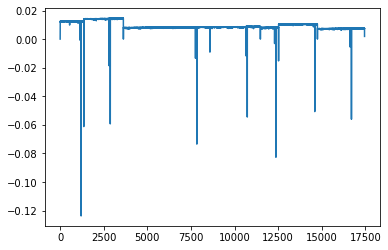

In [229]:

x = np.array([])
for i in range(iter_times_idx.shape[0]):
    s = time[i].flatten()-iter_times_idx[i]
    print(s.shape)
    x = np.append(x,s, axis=0)
    print(x.shape)

plt.plot(x)

In [ ]:
# 3: transform `iterations_raw` into `framenumber_in_trial` and `trialnumber`
# iterations_raw is just a number between 0 and 128. Some math has to be done to obtain:
# framenumber_in_trial has the length of the number of samples of the NIDAQ card, and every entry is the currently presented iteration number of the VR in the respective trial.
# trialnumber has the length of the number of samples of the NIDAQ card, and every entry is the current trial.
#
# NOTE: some minor glitches have to be catched, if a NIDAQ sample happenes to be recorded while the VR System updates the iteration number. 
framenumber_in_trial2 = np.zeros(len(iterations_raw))*np.NaN
current_iter_peaks = 0
current_trial = 0
for idx, frame_number in enumerate(iterations_raw):
    if (idx>recording_start) & (idx<recording_end):

        framenumber_in_trial2[idx] = current_iter_peaks
        if idx in iter_idx:
            current_iter_peaks = current_iter_peaks+1
        
        if idx in trial_start_idx:
            print(framenumber_in_trial[idx-1])
            current_iter_peaks = 0
            current_trial = current_trial + 1
        
        if((current_trial+1) > len(time)):
            soso = idx
            framenumber_in_trial2[idx] = 0
                break
            overflow = 0                       # Reset the 7 bit counter for the next trial

        if overflow == 0:
            framenumber_in_trial[idx] = frame_number  
            if framenumber_in_trial[idx] == 1 and not_printed:
                not_printed = 0
                print(idx)
                
        else:  
            framenumber_in_trial[idx] = frame_number + overflow*32
            
        trialnumber[idx] = current_trial
trial_list = np.array(np.unique(trialnumber[np.isfinite(trialnumber)]), dtype = np.int64)



In [126]:
# 3: transform `iterations_raw` into `framenumber_in_trial` and `trialnumber`
# iterations_raw is just a number between 0 and 128. Some math has to be done to obtain:
# framenumber_in_trial has the length of the number of samples of the NIDAQ card, and every entry is the currently presented iteration number of the VR in the respective trial.
# trialnumber has the length of the number of samples of the NIDAQ card, and every entry is the current trial.
#
# NOTE: some minor glitches have to be catched, if a NIDAQ sample happenes to be recorded while the VR System updates the iteration number. 
framenumber_in_trial = np.zeros(len(iterations_raw))*np.NaN
framenumber_in_trial2 = np.zeros(len(iterations_raw))*np.NaN
trialnumber = np.zeros(len(iterations_raw))*np.NaN
current_trial = 0
not_printed = 1
current_iter_peaks = 0
overflow = 0 # This variable keep track whenever the reset from 127 to 0 happens.
for idx, frame_number in enumerate(iterations_raw):
    if (idx>recording_start) & (idx<recording_end):
        #print(iterations_raw2[idx], frame_number)
        if (frame_number==0) & (iterations_raw[idx-1]==31): # At the reset, add 128
            overflow = overflow + 1
        if (frame_number==0) & (iterations_raw[idx-1]!=31) & (iterations_raw[idx-1]!=0) &  (iterations_raw[idx-2]==31): # Unlucky reset if happened to be sampled at the wrong time
            overflow = overflow + 1
            framenumber_in_trial[idx-1] = frame_number + overflow*32 - 1 # In case this happened, the previous sample has to be corrected
        # Keep track of trial number
        endflag = framenumber_in_trial[idx-1] == (len(time[current_trial])) # Trial end has been reached.
        
        framenumber_in_trial2[idx] = current_iter_peaks
        if idx in iter_idx:
            current_iter_peaks = current_iter_peaks+1
        
        if idx in trial_start_idx:
            print(framenumber_in_trial[idx-1])
            current_iter_peaks = 0
        
        
        #if endflag:
        #    print(framenumber_in_trial[idx-1])
        #    print(frame_number)
        
        transitionflag = frame_number == 1 # Next trial should start at zero again (it starts with two ??)
        if endflag & transitionflag:      # Only at the transitions
            wala = 1000

                
            current_trial = current_trial + 1  # Increases trial count
            if((current_trial+1) > len(time)):
                soso = idx
                framenumber_in_trial[idx] = 0
                trialnumber[idx] = 0
                break
            overflow = 0                       # Reset the 7 bit counter for the next trial

        if overflow == 0:
            framenumber_in_trial[idx] = frame_number  
            if framenumber_in_trial[idx] == 1 and not_printed:
                not_printed = 0
                print(idx)
                
        else:  
            framenumber_in_trial[idx] = frame_number + overflow*32
            
        trialnumber[idx] = current_trial
trial_list = np.array(np.unique(trialnumber[np.isfinite(trialnumber)]), dtype = np.int64)



196683
1.0
1.0
1.0
1.0
1.0
1.0
1.0


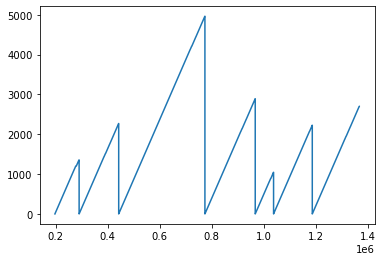

In [127]:
plt.plot(framenumber_in_trial2)

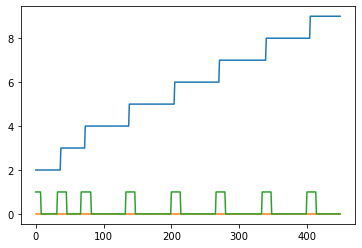

In [118]:
fig, ax = plt.subplots()
ax.plot(framenumber_in_trial[trials_samples[0][2]+50:trials_samples[0][2]+500])
ax.plot(digital_array[1, trials_samples[0][2]+50:trials_samples[0][2]+500])
ax.plot(digital_array[2, trials_samples[0][2]+50:trials_samples[0][2]+500])




#plt.plot(framenumber_in_trial)

In [128]:
peaks, peak_dict = find_peaks(framenumber_in_trial2, height=0)
print(peak_dict['peak_heights'])
print(peaks)
print(trials_samples[0])

[1.000e+00 1.355e+03 2.269e+03 4.961e+03 2.891e+03 1.044e+03 2.226e+03]
[ 196691  289775  441990  773621  967164 1037687 1186602]
[ 196669  289752  441976  773599  967146 1037673 1186579 1367376]


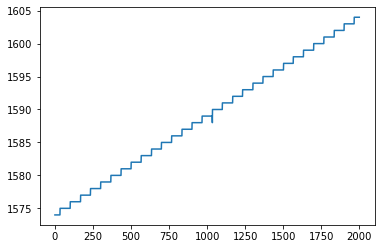

In [84]:
plt.plot(framenumber_in_trial[peaks[2]-1000:peaks[2]+1000])

In [85]:
trial_list

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [86]:
# 4: find and remove additional NIDAQ glitches of two types: 
# a) single samples where the iteration number is corrupted because sampling happened faster than output of the behevior PC.
# b) Skipped frames are detected and filled in.
# Find the glitches
din = np.diff(framenumber_in_trial)
trial_transitions = np.where(np.diff(trialnumber))
not_trial_transitions = np.invert(np.where(np.diff(trialnumber)))
glitches = []
for candidate in np.where( np.logical_or(din>1, din<0) )[0]: # skipped frames or counting down
    #They are only real glitches if candidate index does not correspond to a trial transition
    if np.sum(candidate == trial_transitions) == 0:
        glitches = np.append(glitches, candidate)
glitches = np.array(glitches, dtype = np.int64)
glitches.shape

(30,)

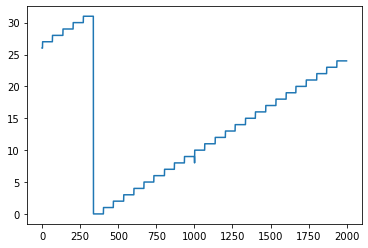

In [87]:
plt.plot(iterations_raw[glitches[0]-1000:glitches[0]+1000])

In [89]:
# Attempt to remove them
skipped_frames = 0
diff_trials = np.diff(framenumber_in_trial)
for g in glitches:
    if framenumber_in_trial[g] < framenumber_in_trial[g+2]:
        #if framenumber_in_trial[g+2] -  framenumber_in_trial[g] == 2:  # skipped frame, should be very rare
        #    if framenumber_in_trial[g+1] == framenumber_in_trial[g+2]:
        #        framenumber_in_trial[g+1] = framenumber_in_trial[g]+1    
        #        print('Case 0-2-2 not skipped')
        #    else:
        #        framenumber_in_trial[g+1] = framenumber_in_trial[g]+1
        #        skipped_frames = skipped_frames + 1
        #else:                          # If random number, nidaq sample in the middle of update.
        framenumber_in_trial[g+1] = framenumber_in_trial[g]

# A set of final asserts, making sure that the code worked as intended  
assert len(trial_list) == len(thissession)          # Make sure the trial number is correct.
assert np.sum(np.diff(framenumber_in_trial)>1) == 0 # No frames should be skipped

#Trial transitions should be same as number of trials -1 
assert np.sum(np.diff(framenumber_in_trial)<0) == len(trial_list) # Negative iterations only at trial transitions


so = np.diff(framenumber_in_trial)<0
su = diff_trials[so]
print(len(su))
print(len(trial_list))

7
7


In [92]:
iterations_test = 0
time_differ = np.zeros(len(trial_list))*np.NaN
for idx,t in enumerate(trial_list):
    idx_nidaq_samples_trial = trialnumber==t
    print(np.max(idx_nidaq_samples_trial))
    current_iter_trial = framenumber_in_trial[idx_nidaq_samples_trial][-1]
    iterations_test = iterations_test + current_iter_trial  # Integrate number of iterations
    print(current_iter_trial)
    #assert current_iter_trial == len(time[t])  # Make sure number of nidaq-frames in each trial is identical to dj record:
    nidaqtime = np.sum(idx_nidaq_samples_trial)/nidq_sampling_rate
    matlabtime = np.max(time[t])
    time_differ[idx] = nidaqtime - matlabtime 
    assert ((nidaqtime - matlabtime) / matlabtime) < 0.1 # # Make sure the nidaq-trial-duration and dj records are consistent; 10% arbitrarily chosen
nidaq_duration = iterations_test
#Dj duration is the iteration start of the last trial minus iteration first trial plus last trial iterations, 
#Or just the sum of each iteration trials
dj_duration = iterstart[-1] - iterstart[0]  + len(time[-1])
print(iterstart[-1])
print(iterstart[0])
print(nidaq_duration)
print(dj_duration)
print(skipped_frames)
assert np.abs(nidaq_duration - dj_duration) == 0 # at most two frames off - sometimes this happens at the beginning/end of the recording


True
0.0


AssertionError: 

In [15]:
num_iter_time = 0
for i in time:
    num_iter_time += i.shape[0]
    print(num_iter_time)
print(iterstart)
print(num_iter_time)

1585
4811
6509
7516
33135
36597
38831
46152
52106
53943
56942
61083
63365
66686
70245
72603
75006
76960
79067
81302
83184
85080
88688
90306
93787
94900
96558
99539
100934
102864
104690
106366
108334
109879
111574
113343
115055
117134
118585
120356
122301
123950
125381
127070
128676
130393
132109
134280
135623
136962
139056
141152
142356
143869
145433
147267
148654
150230
151686
153523
155444
157224
158993
160658
162161
163492
164938
168320
169784
171228
172789
174282
175718
177456
179035
181100
182429
183878
185308
186703
188141
189676
191179
192653
194632
196669
198144
200187
201695
203187
204657
206912
208066
209815
211233
212755
214289
215782
217181
218565
220138
221516
223628
224757
226106
227678
229041
230432
231900
233223
235202
236680
237988
239413
241525
242624
243955
245283
246664
247849
249711
251048
252756
254290
255732
257167
258635
260632
262073
263524
264940
266996
268225
269526
271010
272390
273830
275238
276728
278124
279579
280984
282394
283641
285065
286559
288470
289

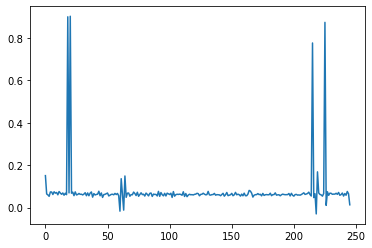

In [262]:
plt.plot(time_differ)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]
1882.0
(1881,)
(1882, 1)
1.0


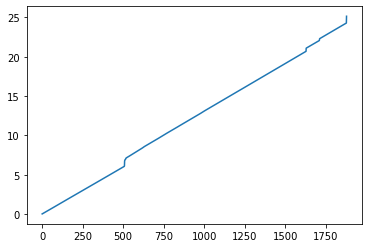

In [263]:
idx_nidaq_samples_trial = trialnumber==20
current_iter_trial = framenumber_in_trial[idx_nidaq_samples_trial]
iter_transitions = np.where(np.diff(current_iter_trial))
time_nidaq = iter_transitions[0]/nidq_sampling_rate
time_nidaq = np.insert(time_nidaq, 0, 0) 

so = (np.diff(current_iter_trial) == 1)

print(current_iter_trial[iter_transitions[0][0]-10:iter_transitions[0][0]+10])


print(current_iter_trial[0:100])

#print(iter_transitions[0][-1])


print(max(current_iter_trial))
print(time_nidaq.shape)
print(time[20].shape)
print(max(np.diff(current_iter_trial)))
plt.plot(iter_transitions[0]/nidq_sampling_rate)
#plt.plot(iter_transitions[0][-1])

In [264]:

final_key = dict(key, nidq_sampling_rate = nidq_sampling_rate, 
               iteration_index_nidq = framenumber_in_trial,
               trial_index_nidq = trialnumber)
final_key

{'subject_fullname': 'ms81_M005',
 'session_date': datetime.date(2021, 5, 5),
 'session_number': 0,
 'nidq_sampling_rate': 5000.071548,
 'iteration_index_nidq': array([nan, nan, nan, ..., nan, nan, nan]),
 'trial_index_nidq': array([nan, nan, nan, ..., nan, nan, nan])}

In [265]:

# If this is done, and the asserts are passed, insert the data into the database
ephys.BehaviorSync.insert1(final_key,allow_direct_insert=True)

# get the imec sampling rate for a particular probe
here = ephys_element.ProbeInsertion & key
for probe_insertion in here.fetch('KEY'):
    imec_bin_filepath = list(session_dir.glob('*imec{}/*.ap.bin'.format(probe_insertion['insertion_number'])))

    if len(imec_bin_filepath) == 1:    # find the binary file to get meta data
        imec_bin_filepath = imec_bin_filepath[0]
    else:                               # if this fails, get the ap.meta file.
        imec_bin_filepath = list(session_dir.glob('*imec{}/*.ap.meta'.format(probe_insertion['insertion_number'])))
        if len(imec_bin_filepath) == 1:
            s = str(imec_bin_filepath[0])
            imec_bin_filepath = pathlib.Path(s.replace(".meta", ".bin"))
        else:   # If this fails too, no imec file exists at the path.
            raise NameError("No imec meta file found.")

    imec_meta = readMeta(imec_bin_filepath)
    ephys.BehaviorSync.ImecSamplingRate.insert1(
        dict(probe_insertion,
             ephys_sampling_rate=imec_meta['imSampRate']), allow_direct_insert=True)

Once the synchronization files have been produces, the all Clusters/spikes can be binned into iterations.

In [278]:
key_samplig = key.copy()
key['insertion_number'] = 0

nidq_sampling_rate, iteration_index_nidq = \
(ephys.BehaviorSync * ephys.BehaviorSync.ImecSamplingRate & key).fetch1(
                'nidq_sampling_rate', 'iteration_index_nidq')


key_session = key.copy()
del key_session["insertion_number"]

thissession = behavior.TowersBlock().Trial() & key
iterstart = thissession.fetch('vi_start')

first_vr_iteration = iterstart[0]

print('first_vr_iteration', first_vr_iteration)

# Obtain the precise times when the frames transition.
# This is obtained from iteration_index_nidq
ls = np.diff(iteration_index_nidq)
ls[ls<0] = 1 # These are the trial transitions (see definition above). To get total number of frames, we define this as a transition like all others. 
ls[np.isnan(ls)] = 0
iteration_transition_indexes = np.where(ls)[0]

# First iterations captured not in virmen because vr was not started yet
for i in range(first_vr_iteration):

    print('iteration_index_nidq[iteration_transition_indexes[i]]', iteration_index_nidq[iteration_transition_indexes[i]])
    if iteration_index_nidq[iteration_transition_indexes[i]] < first_vr_iteration:
        ls[iteration_transition_indexes[i]] = 0
        
        
np.sum(ls)

first_vr_iteration 2
iteration_index_nidq[iteration_transition_indexes[i]] 1.0
iteration_index_nidq[iteration_transition_indexes[i]] 2.0


470540.0

In [5]:
ephys.BehaviorSync.populate(key)

nChan: 1, nFileSamp: 30369867


In [6]:
ephys.CuratedClustersIteration.populate(key)

sum_iterationtrans 470788.0
sum_iterationtrans 470788.0


This allows to plot neuronal responses responses. Here is an example

In [7]:
ephys.CuratedClustersIteration.Unit & key & 'unit = 7'

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,unit,spike_counts_iteration number of spikes during each iteration. have length as the number of iterations - 1,firing_rate_before_first_iteration,firing_rate_after_last_iteration
ms81_M005,2021-05-05,0,0,0,1,7,=BLOB=,0.32816,3.72292
ms81_M005,2021-05-05,0,1,0,1,7,=BLOB=,6.21316,2.39695


In [8]:
ephys.BehaviorSync() & key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
ms81_M005,2021-05-05,0,5000.07,=BLOB=,=BLOB=


In [9]:
spikes = (ephys.CuratedClustersIteration.Unit & key & 'insertion_number = 0' & 'unit = 7').fetch1('spike_counts_iteration')

behavior = dj.create_virtual_module('subject', 'u19_behavior')
pos, time = (behavior.TowersBlock().Trial() & key).fetch('position', 'trial_time')

position_at_each_iteration = []
for trial in range(len(pos)):
    pp = pos[trial][:,1]
    snip = np.zeros(len(time[trial]))*np.NaN
    snip[0:len(pp)] = pp
    position_at_each_iteration = np.append(position_at_each_iteration, snip)

In [10]:
spikes.shape

(470787,)

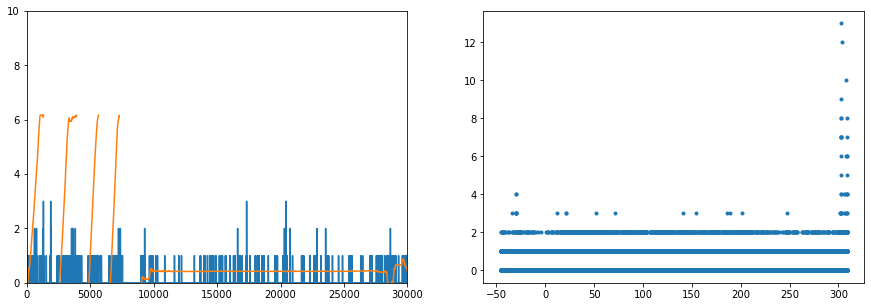

In [11]:
pl.figure(figsize=(15,5))
pl.subplot(1,2,1)
pl.plot(spikes)
pl.plot(position_at_each_iteration/50)
pl.ylim([0,10])
pl.xlim([0,30000])

pl.subplot(1,2,2)
pl.plot(position_at_each_iteration, spikes, '.')

TODO: 
    - Sync table under ephys module.
    - Unit table could contain the clustering results for multiple sorters. U19 team needs to implemnt the workflow for other sorters by overwriting the make function of the table `ephys_element.Clustering`. e.g.
    ```
    def ironclust_make(key):
    if (ephys_element.ClusteringMethod & key).fetch1('clustering_method') != 'ironclust':
        return
    pass
    ephys_element.CuratedClustering.make = ironclust_make
    ephys_element.CuratedClustering.populate()
    ```

In [12]:
        nidq_sampling_rate, iteration_index_nidq = \
            (ephys.BehaviorSync * ephys.BehaviorSync.ImecSamplingRate & key).fetch(
                'nidq_sampling_rate', 'iteration_index_nidq')

In [14]:
iteration_index_nidq[0].shape

(30369867,)